## Projekt Big Data: Analiza nastrojów przy użyciu Pyspark na tweetach odnośnie COVID-19

**Problem**: przeanalizowanie tweetów odnośnie COVID-19 i zrozumienie, jakie nastroje towarzyszą drugiej fali pandemii

**Opis danych:** Używam pobranego zbioru danych z Twitter API, który zawiera szereg kolumn, ale do analizy będę wykorzystywać kolumny: tweet-text, id posta, sentyment obliczony przy użyciu TextBlob biblioteki (NLTK)

**Podejście:** Zastosowałam tradycyjne podejście do analizy sentymentów, a także podejście data science, które obejmuje estymatory, transformatory i zastosowanie algorytmu uczenia maszynowego do mojej analizy nastrojów, gdzie 1 oznacza dodatnie, a 0 ujemne.

#zaimportowanie  numpy, pandas and matplotlib bibliotek do czyszczenia i eksploracyjnej analizy danych

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
pd.RangeIndex(start=0, stop=100000,step=1)

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1610609520899_0007,pyspark3,idle,Link,Link,✔


SparkSession available as 'spark'.
RangeIndex(start=0, stop=100000, step=1)

In [2]:
%%local
%matplotlib inline

#Sprawdzanie zawartości bazy w Apache Hive

In [3]:
%%sql
SHOW TABLES

In [4]:
%%sql
describe tweets_pandemic

#Sprawdzenie jakie mamy tendencje emocjonalne w pobranych tweetach

In [8]:
%%sql
select sentiment, count(*) as cnt from
(select case 
when polarity < 0 then 'negative'  
when polarity = 0 and subjectivity >= 0.5 then 'negative'
when polarity = 0 and subjectivity < 0.5 then 'positive'
when polarity > 0 then 'positive' 
end
as sentiment
from tweets_pandemic)
where sentiment <> 'NaN'
group by sentiment
order by sentiment

#Tworzenie DataFrame na podstawie danych o tweetach w Apache Hive

In [19]:
%%time
%%sql -q -o df -n -1

select id, text as tweet, 
case 
when sentiment_string = 'negative'  then 0
when sentiment_string = 'positive'  then 1
end
as sentiment
from
(select id, text,
 case 
when polarity < 0 then 'negative'  
when polarity = 0 and subjectivity >= 0.5 then 'negative'
when polarity = 0 and subjectivity < 0.5 then 'positive'
when polarity > 0 then 'positive' 
end
as sentiment_string
from tweets_pandemic)
where sentiment_string <> 'NaN'

CPU times: user 3min 9s, sys: 18.4 s, total: 3min 27s
Wall time: 4min 59s


In [20]:
%%local
df.info()
df.index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
id           100000 non-null int64
tweet        100000 non-null object
sentiment    100000 non-null int64
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


RangeIndex(start=0, stop=100000, step=1)

#Nie mamy tej samej liczby pozytywnych i negatywnych tweetów, ale do uczenia maaszynowego wezme taka samo liczbę pozytywnych i negatywnych postów

In [21]:
%%local
df.sentiment.value_counts()

1    83511
0    16489
Name: sentiment, dtype: int64

In [22]:
%%help

Magic,Example,Explanation
info,%%info,Outputs session information for the current Livy endpoint.
cleanup,%%cleanup -f,"Deletes all sessions for the current Livy endpoint, including this notebook's session. The force flag is mandatory."
delete,%%delete -f -s 0,Deletes a session by number for the current Livy endpoint. Cannot delete this kernel's session.
logs,%%logs,Outputs the current session's Livy logs.
configure,"%%configure -f{""executorMemory"": ""1000M"", ""executorCores"": 4}",Configure the session creation parameters. The force flag is mandatory if a session has already been created and the session will be dropped and recreated.Look at Livy's POST /sessions Request Body for a list of valid parameters. Parameters must be passed in as a JSON string.
spark,%%spark -o dfdf = spark.read.parquet('...,"Executes spark commands. Parameters: -o VAR_NAME: The Spark dataframe of name VAR_NAME will be available in the %%local Python context as a Pandas dataframe with the same name. -m METHOD: Sample method, either take or sample. -n MAXROWS: The maximum number of rows of a dataframe that will be pulled from Livy to Jupyter. If this number is negative, then the number of rows will be unlimited. -r FRACTION: Fraction used for sampling."
sql,%%sql -o tables -qSHOW TABLES,"Executes a SQL query against the variable sqlContext (Spark v1.x) or spark (Spark v2.x). Parameters: -o VAR_NAME: The result of the SQL query will be available in the %%local Python context as a Pandas dataframe. -q: The magic will return None instead of the dataframe (no visualization). -m, -n, -r are the same as the %%spark parameters above."
local,%%locala = 1,All the code in subsequent lines will be executed locally. Code must be valid Python code.


### 1.Czyszczenie danych

In [23]:
%%local
df.tweet[15]

u'RT @realDonaldTrump: \u201cThe President was responsible for those direct payments to Americans in the Covid-19 Relief Bill.\u201d @kilmeade @foxandf\u2026'

#importowanie bibliotek potrzebnych do czyszczenia tekstu w tweetach
#testowanie wyników dla recenzji numer 15 i mozna zauważyć, że tagi HTML (u" i \u) zostały usunięte.

In [24]:
%%local
from bs4 import BeautifulSoup
import re
test = BeautifulSoup(df.tweet[15], 'lxml')
print(test.get_text())

RT @realDonaldTrump: “The President was responsible for those direct payments to Americans in the Covid-19 Relief Bill.” @kilmeade @foxandf…


#importowanie funkcji biblioteki NTLK „WordPunctTokenizer”, która dzieli ciąg na podciągi przez dzielenie.

In [25]:
%%local
from nltk.tokenize import WordPunctTokenizer
token = WordPunctTokenizer()

reg1 = r'@[A-Za-z0-9]+' # usuwanie liczb i znaków specjalnych
reg2 = r'<[^<]+?>'  # usuwanie znaków specjalnych
comb = r'|'.join((reg1, reg2)) # łączę obie zmienne regresji i uzyję ich poniżej w funkcji.

#funkcja „clean” do czyszczenia tekstu 

In [26]:
%%local
def clean(tweet):
    s = BeautifulSoup(tweet, 'lxml')
    s_soup = s.get_text()
    strip = re.sub(comb, '', s_soup)
    letter = re.sub("[^a-zA-Z]", " ", strip)
    lower = letter.lower()
    replaceprefix = re.sub("^u'", "'", lower) 
    word = token.tokenize(replaceprefix)
    return (" ".join(word)).strip()

#testowanie funkcji

In [27]:
%%local
test = df.tweet[:16]

result = []  #pusty ciąg dodawany przy każdej iteracji czyszczenia tweetów.
for t in test:
    result.append(clean(t)) # wywołanie funkcji clean
    
result

[u'la russie d nonce et expose l agenda secret du nouvel ordre mondial sur le covid',
 u'rt hong kong on monday said it would ban all flights from britain following the discovery of a new and highly infectious strain of th',
 u'sanchez uy ayaw na pavideo kase nahuli siyang nagpaparty habang pandemic trauma ka ghorl stupid mo banda diyan',
 u'the nhs will be offering the covid vaccine over the coming weeks and months',
 u'rt monye there is a new strain of covid that leaves you blind',
 u'rt chuck collins',
 u'rt and the only reason mitch mcconnell is allowing a coronavirus relief bill to go forward at this time is that',
 u'rt what if the true meaning of christmas is not fueling a fucking pandemic',
 u'can t wait for this pandemic to be over not for health reasons so i do https t co yqxr dll',
 u'update data sebaran kasus covid di kabupaten bantul berdasarkan data dari dinas kesehatan kabupaten bantul per https t co u kqoazuf',
 u'rt dg here s my brave and beautiful elder daughter laura

#### Teraz czyszcze całe dane w kolumnie tweet. Podzieliłam tweety na 2 części i będę czyścić stopniowo, aby skrócić czas pracy.

In [28]:
%%local
%%time
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
n = [0,50000,100000] 
print ("Czyszczenie część 1")
clean_tweet = []
for i in range(n[0],n[1]):                                                                
    clean_tweet.append(clean(df['tweet'][i]))

Czyszczenie część 1
CPU times: user 42.8 s, sys: 2.83 s, total: 45.6 s
Wall time: 46.7 s


In [29]:
%%local
%%time
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
n = [0,50000,100000] 
print ("Czyszczenie część 2")
for i in range(n[1],n[2]):                                                                
    clean_tweet.append(clean(df['tweet'][i]))

Czyszczenie część 2
CPU times: user 42.9 s, sys: 3.31 s, total: 46.2 s
Wall time: 48.6 s


In [30]:
%%local
len(clean_tweet) #liczba wyczyszczonych tweetów

100000

#### Zapisanie wyczyszczonych tweetów do pliku typu parquet

In [31]:
%%local
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
pd.RangeIndex(start=0, stop=100000,step=1)

RangeIndex(start=0, stop=100000, step=1)

In [32]:
%%local
df_new = pd.DataFrame(clean_tweet,columns=['tweet'])
df_new['id'] = df.id
df_new['sentiment'] = df.sentiment
df_new.head()

In [33]:
%%local
len(df_new)

100000

In [38]:
%%local
df_new.info()
df_new.index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
tweet        100000 non-null object
id           100000 non-null int64
sentiment    100000 non-null int64
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


RangeIndex(start=0, stop=100000, step=1)

In [120]:
%%local
import sys
print(sys.executable)
from wordcloud import WordCloud

/usr/bin/anaconda/bin/python


ImportError: No module named wordcloud

In [115]:
%%local
%%time
import os
#df_new.to_csv('/HdiSamples/tweets_pandemic_clean_3.csv',encoding='utf-8')
df_new.write.format("com.databricks.spark.csv").option("header", "true").save("tweets_pandemic_clean.csv")

AttributeError: 'DataFrame' object has no attribute 'write'

### 2. Eksploracyjna analiza danych

1. Do wizualizacji użyłam Wordcloud, aby zobaczyć częstotliwość słów zgodnie z kolumną tweet. 
<br>
2. Tworzony jest wykres słupkowy, aby wykreślić całkowitą liczbę pozytywnych i negatywnych słów dla ogólnego porównania nastrojów.

In [121]:
%%local
import collections
#from wordcloud import WordCloud #zaimportować wordcloud biblioteke
import matplotlib.pyplot as plt

#Konwertuję ramkę danych na typ danych str, abym mogła podać je jako dane wejściowe w chmurze słów.

In [56]:
%%local
arr = df_new.tweet.values
obj = np.array2string(arr, precision=2, separator=',',suppress_small=True)
type(obj)

str

####  1: Word Cloud służy do wyświetlania najczęściej używanych słów w tweetach.

In [ ]:
%%local
wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(obj)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [73]:
%%local
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
df_split = pd.DataFrame(obj.split())
df_split.head()

TraitError: Invalid selection

,0
0,[
1,u'la
2,russie
3,d
4,nonce


In [74]:
%%local
df_tokenized = pd.DataFrame(WordPunctTokenizer().tokenize(obj), columns=['word'])
df_tokenized.head()

Widzimy różnicę między tokenizerem a funkcją split z powyższych dwóch przypadków. Tokenizer oddziela również znaki specjalne od danych, dlatego używamy tokenizera.
<br>
#### Z poniższego wykresu słupkowego możemy wywnioskować, że ogólny nastrój z tweetów jest pozytywny

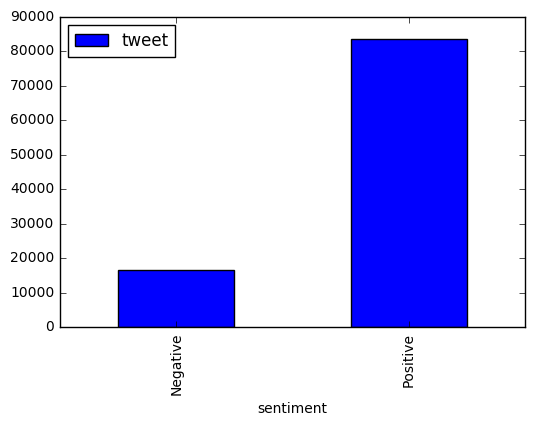

In [78]:
%%local
df_grouped = df_new.groupby('sentiment', as_index = False).count()


labels_word = ['Negative','Positive']
ax = df_grouped.plot(kind = 'bar', x = 'sentiment', y='tweet')
ax.set_xticklabels(labels_word)

### 3. Prosta metoda wykonywania analizy nastrojów.

Używam prostego podejścia do przeprowadzania  analizy i będę używać czystego zestawu danych „tweet_clean”, który stworzyłam w poprzedniej sekcji.
<br>
#importowanie bibliotek Spark API do przyszłej analizy w kontekście Spark SQL.

In [79]:
%%local
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import functions as fn 
import findspark
findspark.init()
import warnings

ImportError: No module named findspark

In [84]:
%%local
conf = SparkConf().setMaster("local[4]").setAppName("Sentiment_Project")  # działam w klastrze z 4 węzłami, ale jest on skalowalny również dla środowiska wieloklastrowego.
sc = SparkContext.getOrCreate(conf = conf)
sqlContext = SQLContext(sc)

#tworzenie kontekstu sql do odczytu wyczyszczonych danych w ramce danych spark sql

In [98]:
%%local
tweet_clean_df = sqlContext.read.format('csv').options(header = 'true', inferschema='true').load('tweets_pandemic_clean_2.csv')

AnalysisException: u'Path does not exist: wasb://sentiment-analysis-hdin@sentimenthdinsight.blob.core.windows.net/user/spark/tweets_pandemic_clean_2.csv;'

In [108]:
%%local

df_clean_spark_ = sc.createDataFrame(df_new)
type(df_clean_spark_)

AttributeError: 'SparkContext' object has no attribute 'conf'

In [110]:
%%local
data = sc.textFile("/HdiSamples/HdiSamples/SensorSampleData/hvac/HVAC.csv")
from pyspark import SparkFiles


In [93]:
%%local
##from azure.storage.blob import BlockBlobService
##import pandas as pd
##import io


accountName = "sentimenthdinsight"
##accountKey = "t/LkO9/Ujau64yxcK48x2Y4SzMIBN5WFoer4C8dD6Xt+S2pn1gf9tcNWlboUFLQwTdUmfOB6fQnnw9NAGiOp8A=="
containerName = "sentiment-analysis-hdin"
##blobName = "tweets_pandemic_clean_.csv"

##blobService = BlockBlobService(account_name=accountName, account_key=accountKey)

##blobService.create_blob_from_text(containerName, blobName, df_new)
output_container_path = "tutorials"


containerName = "sentiment-analysis-hdin"
storageAccountName = "sentimenthdinsight"
sas = "?sv=2019-12-12&ss=bfqt&srt=sco&sp=rwdlacupx&se=2021-01-14T21:42:03Z&st=2021-01-14T13:42:03Z&spr=https&sig=c2AvRTH8emh97UcmDa%2F%2BqT%2BzKrSnxGWP%2Blz5hLiVfKU%3D"
config = "fs.azure.sas." + containerName+ "." + storageAccountName + ".blob.core.windows.net"




output_container_path = "wasbs://%s@%s.blob.core.windows.net" % (containerName, accountName)
output_blob_folder = "%s/" % output_container_path

from azure.storage.blob import BlobServiceClient

ImportError: cannot import name BlobServiceClient

In [94]:
import sys
sys.path

['/mnt/resource/hadoop/yarn/local/usercache/livy/appcache/application_1610609520899_0007/container_1610609520899_0007_01_000001/tmp', '/mnt/resource/hadoop/yarn/local/usercache/livy/appcache/application_1610609520899_0007/spark-e9e267da-2a85-4ee1-b3b0-f1dabcbcc536/userFiles-ca4ed4f6-0799-4bea-9847-4073b9a96086', '/usr/hdp/current/spark2-client/python', '/usr/hdp/current/spark2-client/python/lib/py4j-0.10.7-src.zip', '/mnt/resource/hadoop/yarn/local/usercache/livy/appcache/application_1610609520899_0007/container_1610609520899_0007_01_000001/pyspark.zip', '/mnt/resource/hadoop/yarn/local/usercache/livy/appcache/application_1610609520899_0007/container_1610609520899_0007_01_000001/py4j-0.10.7-src.zip', '/usr/bin/anaconda/envs/py35/lib/python35.zip', '/usr/bin/anaconda/envs/py35/lib/python3.5', '/usr/bin/anaconda/envs/py35/lib/python3.5/plat-linux', '/usr/bin/anaconda/envs/py35/lib/python3.5/lib-dynload', '/usr/bin/anaconda/envs/py35/lib/python3.5/site-packages', '/usr/bin/anaconda/envs/p